# MLP

Try MLP of size 256, 128, 64 and relu activation. 

Run on coding RNA for first cell line.

5-fold cross-validation accuracy was 67%.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-16 09:49:14.111769
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization

dt='float32'
tf.keras.backend.set_floatx(dt)

from KmerCounter import KmerCounter
K=4
counter = KmerCounter()
counter.setK(K)
VOCABULARY_SIZE = counter.get_vocabulary_size()

from TrainValidSplit import Splitter
EPOCHS=10

from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_coding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
COUNTS_FILE='CNRCI_coding_train_counts.K4.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Load labels and sequences

In [5]:
print(datetime.now())
splitter=Splitter()
print(datetime.now())

2022-10-16 09:49:33.837561
2022-10-16 09:49:33.839332


In [6]:
RCI_THRESHOLDS=(0.083,0.083)   # use mean instead of -1, +1
print(datetime.now())
atlas_path = ATLAS_DIR+RCI_FILE
gene_to_label = splitter.load_labels(
    atlas_path,CELL_LINE_NUMBER,RCI_THRESHOLDS)
print(datetime.now())

2022-10-16 09:49:33.860161
ATLAS Genes: 13930
Filter for genes with RCI labels from cell line: 0
Labeled genes: 10354
Positive labels: 5074
2022-10-16 09:49:33.949733


In [7]:
print(datetime.now())
gencode_path = GENCODE_DIR+COUNTS_FILE
gid_tid_label,ordered_kmer_counts = splitter.load_transcripts(gencode_path,gene_to_label)
print(datetime.now())

2022-10-16 09:49:33.974883
2022-10-16 09:49:37.320045


In [8]:
print('Total genes with labels for this cell line:',len(gene_to_label))
print('Total labeled transcript IDs :',len(gid_tid_label))
print('Total transcript K-mer counts:',len(ordered_kmer_counts))
if (len(gid_tid_label)==len(ordered_kmer_counts)):
    print('Looks good!')
else:
    print('Why are these totals different?')

Total genes with labels for this cell line: 10354
Total labeled transcript IDs : 54351
Total transcript K-mer counts: 54351
Looks good!


In [9]:
#print(datetime.now())
#INPUT_BINARY = GENCODE_DIR+COUNTS_FILE # same order as load_transcripts()
#ordered_kmer_counts = np.load(INPUT_BINARY,allow_pickle=True)
#print(datetime.now())

In [10]:
print(datetime.now())
splitter.set_ids(gid_tid_label)
splitter.set_counts(ordered_kmer_counts)
splitter.randomize()
print(datetime.now())

2022-10-16 09:49:37.404737
2022-10-16 09:49:37.424850


## Build model

In [14]:
def build_model():
    act='relu'
    dense1_layer = keras.layers.Dense(256, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(128, activation=act,dtype=dt)
    dense3_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation='sigmoid',dtype=dt)

    mlp = keras.models.Sequential()
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    mlp.add(dense3_layer)
    mlp.add(output_layer)
    
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

## Cross validation

In [15]:
def do_cross_validation(splitter,eps):
    cv_scores = []
    fold=0
    PARTITIONS=5
    for i in range(PARTITIONS):
        X_train,y_train,X_valid,y_valid = \
            splitter.train_valid_split(i,PARTITIONS)
        print('Fold',i)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        fold += 1
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


2022-10-16 09:52:04.663009
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 107,009
Trainable params: 107,009
Non-trainable params: 0
_________________________________________________________________
None
Cross valiation
Fold 0
Train set ones/size 20257 / 43333
Valid set ones/size 5211 / 11018
BUILD MODEL
COM

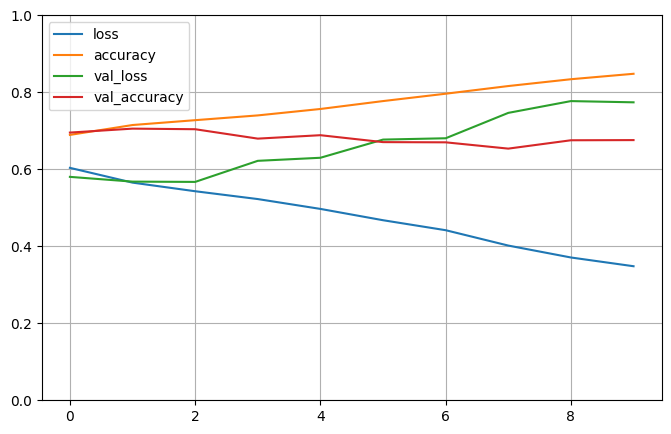

accuracy: 67.58%
Fold 1
Train set ones/size 20407 / 43334
Valid set ones/size 5061 / 11017
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1355/1355 [==============================] - 5s 3ms/step - loss: 0.6022 - accuracy: 0.6913 - val_loss: 0.5788 - val_accuracy: 0.7078
Epoch 2/10
1355/1355 [==============================] - 4s 3ms/step - loss: 0.5551 - accuracy: 0.7167 - val_loss: 0.5709 - val_accuracy: 0.7107
Epoch 3/10
1355/1355 [==============================] - 4s 3ms/step - loss: 0.5342 - accuracy: 0.7301 - val_loss: 0.5876 - val_accuracy: 0.7070
Epoch 4/10
1355/1355 [==============================] - 4s 3ms/step - loss: 0.5115 - accuracy: 0.7444 - val_loss: 0.6189 - val_accuracy: 0.6975
Epoch 5/10
1355/1355 [==============================] - 4s 3ms/step - loss: 0.4815 - accuracy: 0.7676 - val_loss: 0.6198 - val_accuracy: 0.7065
Epoch 6/10
1355/1355 [==============================] - 4s 3ms/step - loss: 0.4471 - accuracy: 0.7882 - val_loss: 0.6989 - val_accuracy: 0.6846
Epoch 

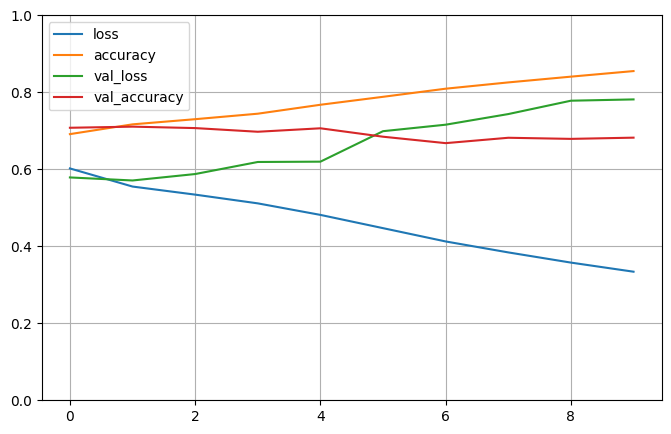

accuracy: 68.21%
Fold 2
Train set ones/size 20617 / 43559
Valid set ones/size 4851 / 10792
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1362/1362 [==============================] - 5s 3ms/step - loss: 0.6086 - accuracy: 0.6862 - val_loss: 0.5731 - val_accuracy: 0.7031
Epoch 2/10
1362/1362 [==============================] - 5s 4ms/step - loss: 0.5646 - accuracy: 0.7098 - val_loss: 0.5800 - val_accuracy: 0.7063
Epoch 3/10
1362/1362 [==============================] - 5s 3ms/step - loss: 0.5435 - accuracy: 0.7255 - val_loss: 0.5794 - val_accuracy: 0.7052
Epoch 4/10
1362/1362 [==============================] - 5s 3ms/step - loss: 0.5189 - accuracy: 0.7412 - val_loss: 0.6166 - val_accuracy: 0.6840
Epoch 5/10
1362/1362 [==============================] - 5s 3ms/step - loss: 0.4896 - accuracy: 0.7609 - val_loss: 0.6564 - val_accuracy: 0.6958
Epoch 6/10
1362/1362 [==============================] - 5s 3ms/step - loss: 0.4580 - accuracy: 0.7813 - val_loss: 0.6258 - val_accuracy: 0.6934
Epoch 

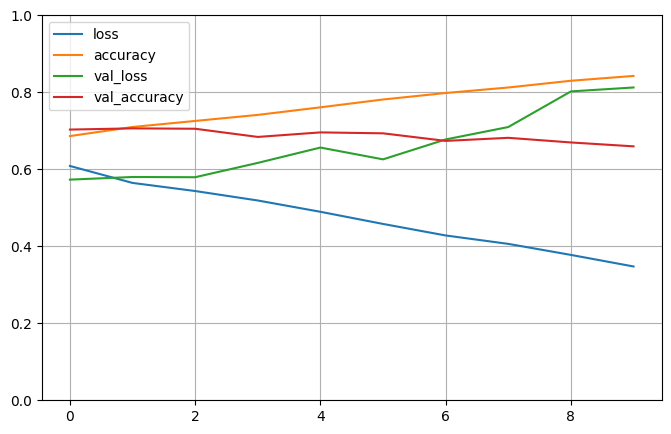

accuracy: 65.96%
Fold 3
Train set ones/size 20261 / 43700
Valid set ones/size 5207 / 10651
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1366/1366 [==============================] - 5s 3ms/step - loss: 0.6020 - accuracy: 0.6913 - val_loss: 0.6110 - val_accuracy: 0.6868
Epoch 2/10
1366/1366 [==============================] - 4s 3ms/step - loss: 0.5555 - accuracy: 0.7180 - val_loss: 0.5854 - val_accuracy: 0.6933
Epoch 3/10
1366/1366 [==============================] - 4s 3ms/step - loss: 0.5371 - accuracy: 0.7287 - val_loss: 0.5849 - val_accuracy: 0.6972
Epoch 4/10
1366/1366 [==============================] - 4s 3ms/step - loss: 0.5151 - accuracy: 0.7446 - val_loss: 0.5864 - val_accuracy: 0.6940
Epoch 5/10
1366/1366 [==============================] - 4s 3ms/step - loss: 0.4927 - accuracy: 0.7593 - val_loss: 0.6385 - val_accuracy: 0.6870
Epoch 6/10
1366/1366 [==============================] - 4s 3ms/step - loss: 0.4600 - accuracy: 0.7795 - val_loss: 0.6618 - val_accuracy: 0.6833
Epoch 

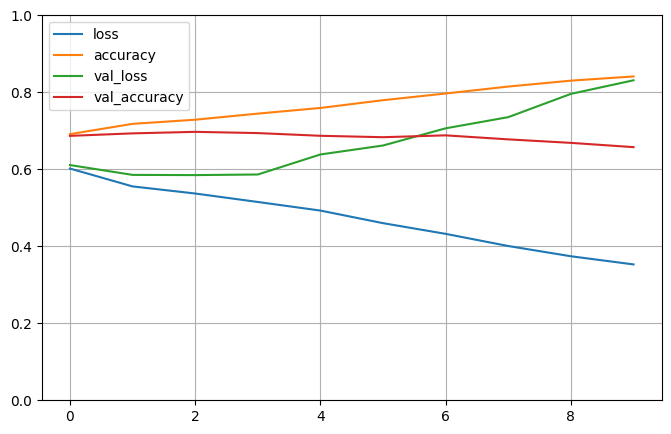

accuracy: 65.75%
Fold 4
Train set ones/size 20330 / 43478
Valid set ones/size 5138 / 10873
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1359/1359 [==============================] - 5s 3ms/step - loss: 0.6015 - accuracy: 0.6885 - val_loss: 0.6365 - val_accuracy: 0.7105
Epoch 2/10
1359/1359 [==============================] - 5s 3ms/step - loss: 0.5576 - accuracy: 0.7153 - val_loss: 0.5921 - val_accuracy: 0.7129
Epoch 3/10
1359/1359 [==============================] - 4s 3ms/step - loss: 0.5348 - accuracy: 0.7321 - val_loss: 0.6034 - val_accuracy: 0.7005
Epoch 4/10
1359/1359 [==============================] - 5s 3ms/step - loss: 0.5132 - accuracy: 0.7450 - val_loss: 0.5997 - val_accuracy: 0.6936
Epoch 5/10
1359/1359 [==============================] - 5s 3ms/step - loss: 0.4851 - accuracy: 0.7629 - val_loss: 0.6505 - val_accuracy: 0.6753
Epoch 6/10
1359/1359 [==============================] - 4s 3ms/step - loss: 0.4524 - accuracy: 0.7843 - val_loss: 0.7024 - val_accuracy: 0.6683
Epoch 

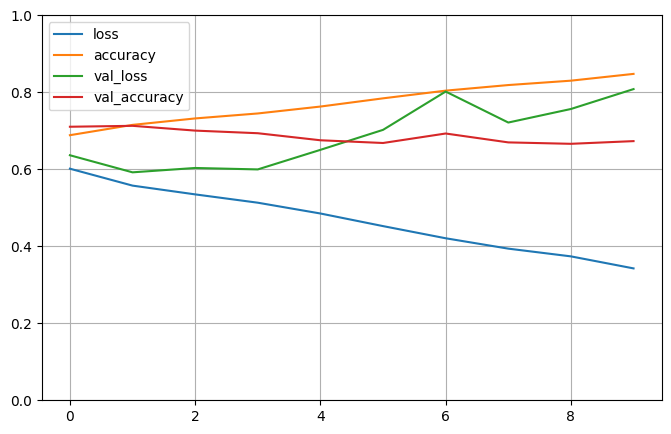

accuracy: 67.31%

Validation core mean 66.96% (+/- 0.95%)
2022-10-16 09:55:59.792785


In [16]:
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

print ("Cross valiation")
do_cross_validation(splitter,EPOCHS)
print(datetime.now())